#  Time series analysis

In [34]:
# Libraries for analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from scipy.signal import periodogram

In [2]:
# Importing the training data
train = pd.read_csv(r'C:\Users\Laptop\Downloads\Data Analytics\VS code\Datasets\Time series of kaggle store\train.csv',
                    index_col='date',
                    parse_dates=['date'],
                    infer_datetime_format=True,
                    usecols=lambda column: column not in ['id'])

# Importing the test data
test = pd.read_csv(r'C:\Users\Laptop\Downloads\Data Analytics\VS code\Datasets\Time series of kaggle store\test.csv',
                   index_col='date',
                   parse_dates=['date'],
                   infer_datetime_format=True,
                   usecols=lambda column: column not in ['id'])

# Converting the datetime in to period datatype
train.index = train.index.to_period('D')
test.index = test.index.to_period('D')

C:\Users\Laptop\AppData\Local\Temp\ipykernel_11524\2294308849.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  train = pd.read_csv(r'C:\Users\Laptop\Downloads\Data Analytics\VS code\Datasets\Time series of kaggle store\train.csv',
C:\Users\Laptop\AppData\Local\Temp\ipykernel_11524\2294308849.py:9: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  test = pd.read_csv(r'C:\Users\Laptop\Downloads\Data Analytics\VS code\Datasets\Time series of kaggle store\test.csv',


**train.csv** - the training set, which includes the sales data for each date-country-store-item combination.  
**test.csv** - the test set; your task is to predict the corresponding item sales for each date-country-store-item combination.

# Exploratory Data Analysis

In [3]:
train.head()

,country,store,product,num_sold
date,,,,
2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63
2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66
2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9
2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59
2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49


**Columns:**
- **Date:** date from 2017 to 2021 in a daily frequency
- **Country:** countries in which we operate(Argentina, Spain, Japan, Canada and Estonia)
- **Store:** stores we have(Kagglazon, Kaggle Learn, Kaggle Store)
- **Products:** products that we sell(Using LLMs to Improve Your Coding, Using LLMs to Train More LLMs, Using LLMs to Win Friends and Influence People, Using LLMs to Win More Kaggle Competitions, Using LLMs to Write Better)
- **num_sold:** Our sales over the time period

In [4]:
print('Information:')
print(train.info())
print('-'* 75)
print('Description:')
print(train.describe().T)

Information:
<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 136950 entries, 2017-01-01 to 2021-12-31
Freq: D
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   country   136950 non-null  object
 1   store     136950 non-null  object
 2   product   136950 non-null  object
 3   num_sold  136950 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 5.2+ MB
None
---------------------------------------------------------------------------
Description:
             count        mean         std  min   25%   50%    75%     max
num_sold  136950.0  165.522636  183.691575  2.0  46.0  98.0  184.0  1380.0


Dataypes look ok and we have no duplicates but I think we have outlier.  
Lets check

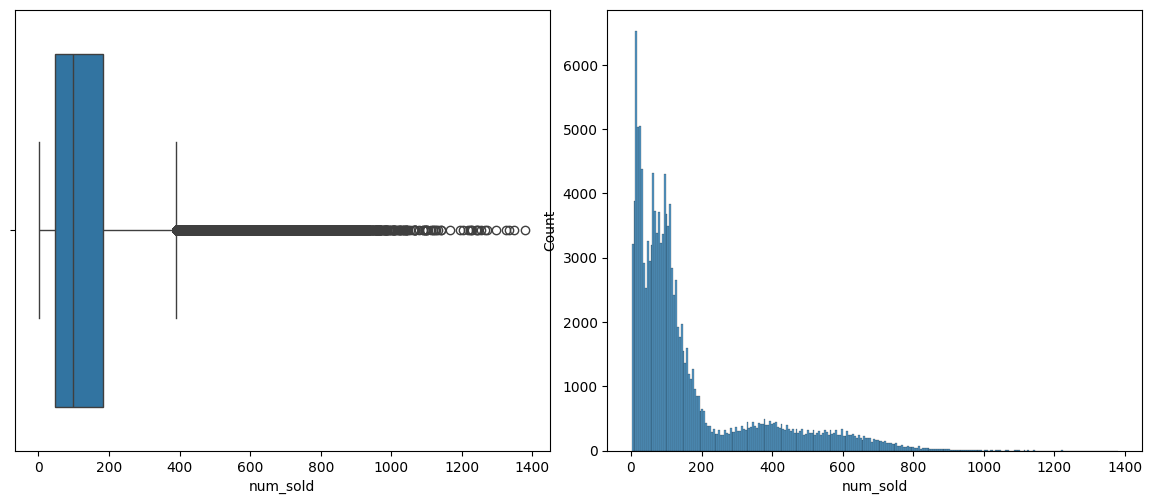

In [5]:
plt.subplots(1, 2, figsize=(12, 5))  # Adjust the figsize as needed
plt.tight_layout()  # Ensures proper spacing between subplots

ax1 = plt.subplot(1, 2, 1)  # Creating the first subplot
sns.boxplot(data=train, x='num_sold', ax=ax1)  # Plotting the boxplot on the first subplot

ax2 = plt.subplot(1, 2, 2)  # Creating the second subplot
sns.histplot(data=train, x='num_sold', ax=ax2)  # Plotting the histogram on the second subplot

plt.show()  # Display the plot

We can see that our data is highly skewed and contains outliers. But in time series data most of the time these outliers have some meaning. They can be due to some specific events along the time(holisays, disasters)

# Trend

First we will create a dataset trend form the original dataset for analysis

In [6]:
trend = train.groupby(train.index).sum()['num_sold'].to_frame()
trend['trend'] = range(1, len(trend) + 1)
trend.set_index('trend', inplace=True)

Now we will observe the trend by plotting it and also performing ADF test of stationarity to check if our data is stationary or not. This is a statistical test commonly used to determine if a time series is stationary. The null hypothesis of the ADF test is that the time series has a unit root (i.e., it is non-stationary).

ADF Statistic: -1.256546208088527
p-value: 0.6488107600677919
Critical Values:
	1%: -3.4339840952648695
	5%: -2.8631452508003057
	10%: -2.567624583142913


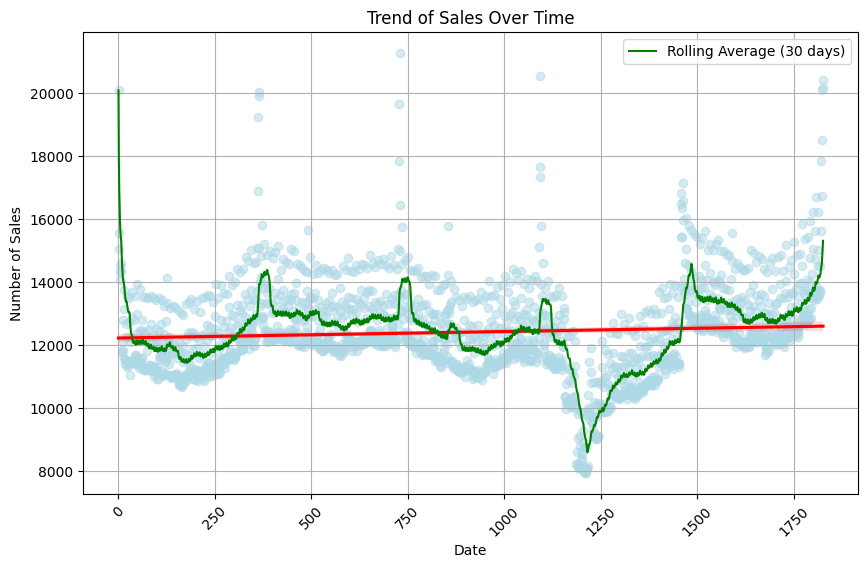

In [33]:
result = adfuller(trend)
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

    
plt.figure(figsize=(10, 6))
sns.regplot(data=trend, x=trend.index, y='num_sold', scatter_kws={"color": "lightblue", "alpha": 0.5}, line_kws={"color": "red"})  # Plot the data points and the regression line

# Add a rolling average trend line
rolling_mean = trend['num_sold'].rolling(window=30, min_periods=1).mean()
sns.lineplot(data=trend, x=trend.index, y=rolling_mean, color='green', label='Rolling Average (30 days)')

# Beautify the plot
plt.title('Trend of Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

As the ADF statistics id greater than crital values and p-value is greater than 0.005(a treshold value), we conclude that our data is non-stationary and we don't we enough evidence to reject the null hypothesis. We can also observe it from the plot that our data has variable mean and varience over time and it has a slight upword trend

# Serial Dependence 

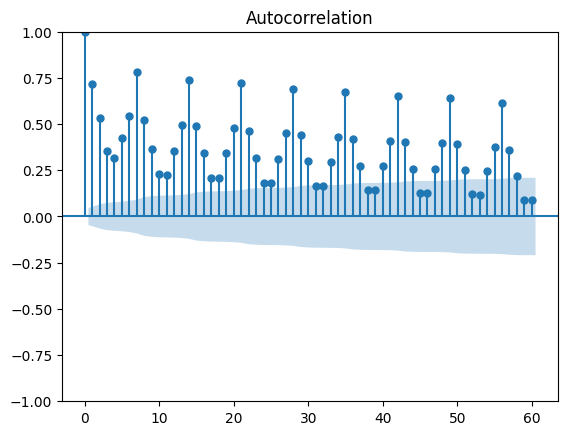

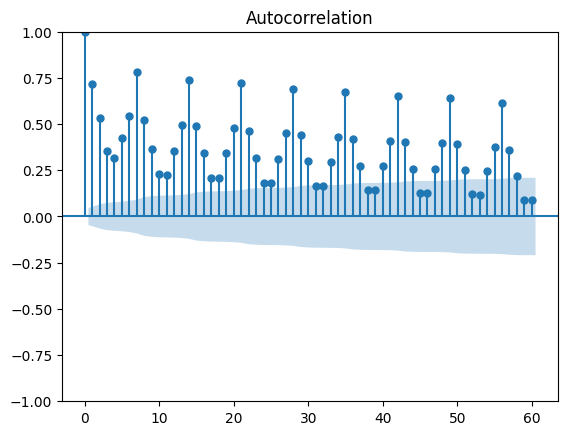

In [28]:
plot_acf(trend, lags=60)

We can see our data is showing weekly seasonality and and a long term trend as we saw above

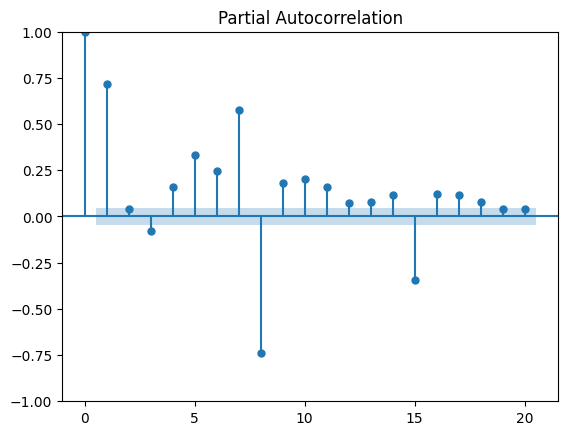

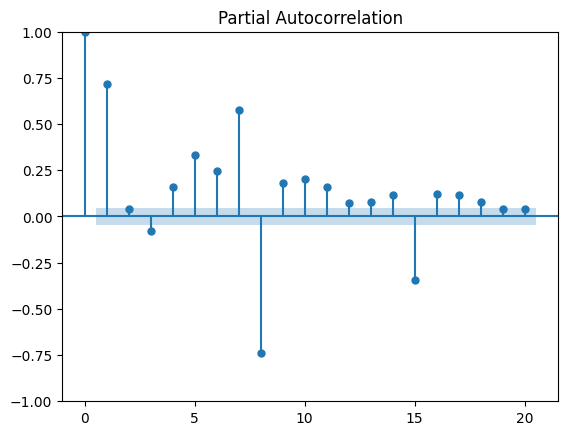

In [30]:
plot_pacf(trend, lags=20)

We can observe from the partial autocorrelation plot that our data id correlated with the 1,4,5,6,7,8 th lags

# Patterns


Now we will create a function that gives the over all pattern of different category sales over time. This will help us observe the pattern of sales for every value of each category column

In [105]:
def plot_pattern(dataset, categorical_column, title, x_label, y_label):
    # Plot overall sales over time for each unique value
    fig, ax = plt.subplots(figsize=(10, 6))
    for value in dataset[categorical_column].unique():
        data = dataset[dataset[categorical_column] == value]['num_sold'].resample('D').sum()
        data.index = data.index.to_timestamp()
        data.plot(ax=ax, label=value)
    ax.set_title(f'Overall Sales Over Time for {title}')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    plt.xticks(rotation=45)
    plt.legend(title=categorical_column)
    plt.show()

    # Plot weekly seasonality for each unique value
    fig, ax = plt.subplots(figsize=(10, 6))
    for value in dataset[categorical_column].unique():
        data = dataset[dataset[categorical_column] == value]['num_sold'].resample('W').sum()
        data.index = data.index.to_timestamp()
        data.plot(ax=ax, label=value)
    ax.set_title(f'Smoother {title} sales over time(weekly)')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    plt.xticks(rotation=45)
    plt.legend(title=categorical_column)
    plt.show()

    # Plot yearly seasonality for each unique value
    fig, ax = plt.subplots(figsize=(10, 6))
    for value in dataset[categorical_column].unique():
        data = dataset[dataset[categorical_column] == value]['num_sold'].resample('Y').sum()
        data.index = data.index.to_timestamp()
        data.plot(ax=ax, label=value)
    ax.set_title(f'Smoother {title} sales over time(yearly)')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    plt.xticks(rotation=45)
    plt.legend(title=categorical_column)
    plt.show()

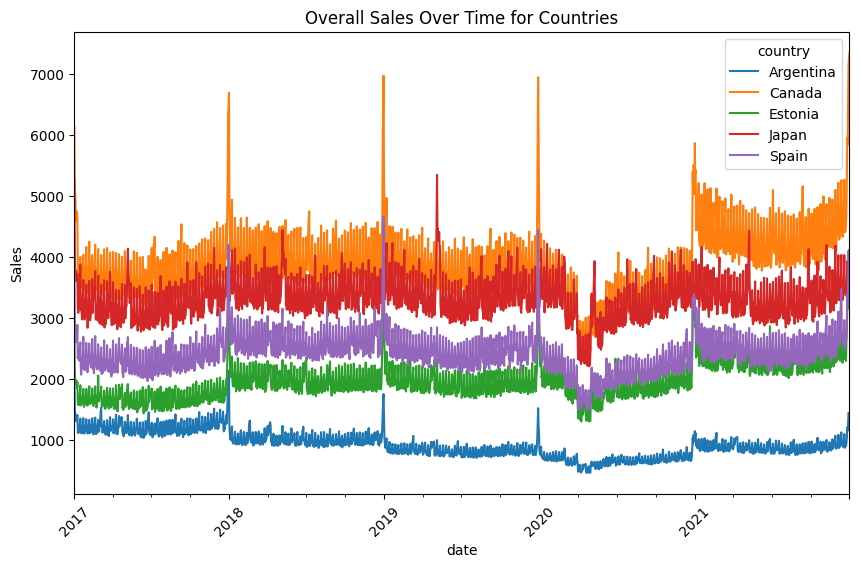

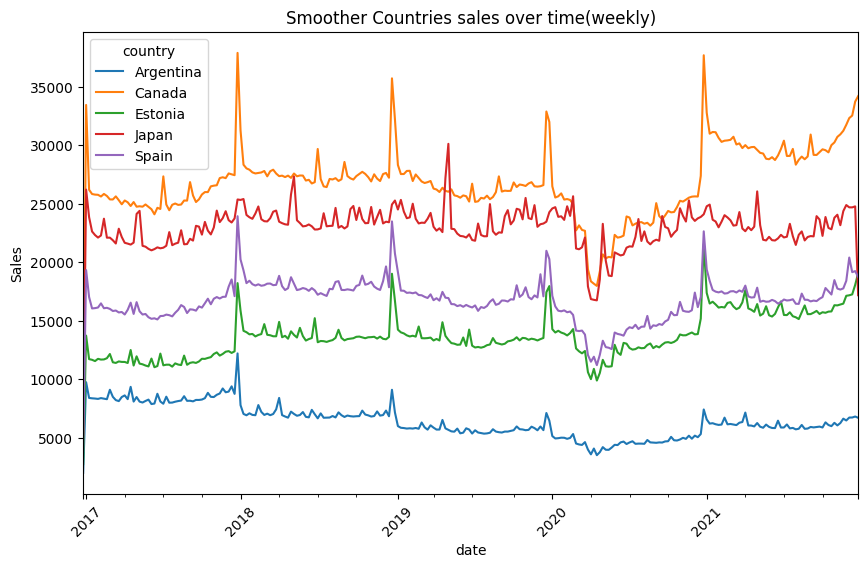

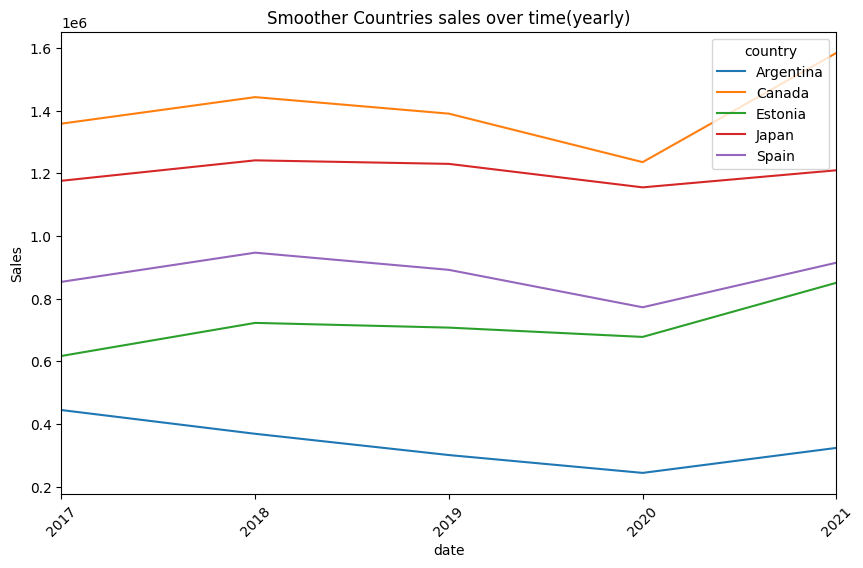

In [106]:
# Plotting pattern for country column
plot_pattern(train,'country','Countries','date','Sales')

**From the above plot:**
- we can see that the sales comparison of each country
- We can observe a jump at the start of every year except for Japan, wondering why? Instead we see a jump in sales in April for Japan
- There is a dump in the sales of every country in the start of second quarter of 2020. But over sales recovered after that dump 
- Every country's sales took a good start from 2017(start of over sales data) except argentina which had a down trend till 2020


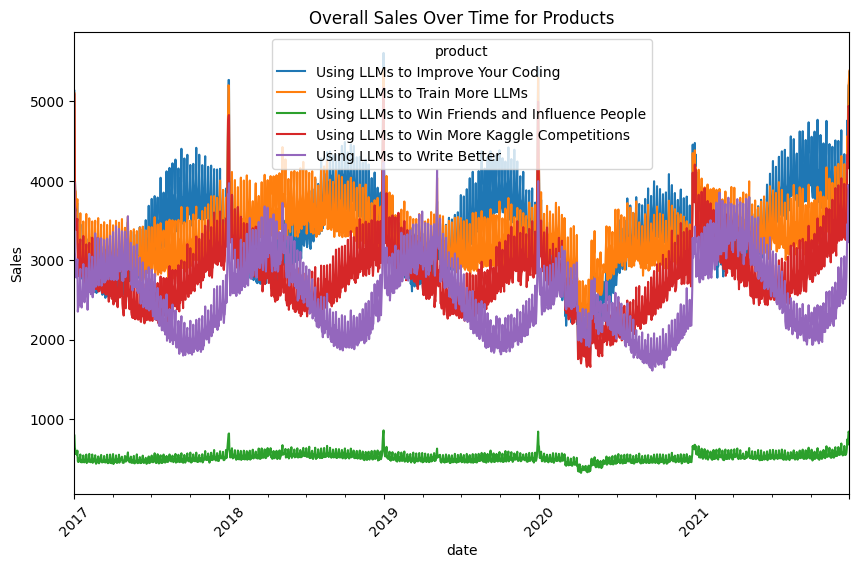

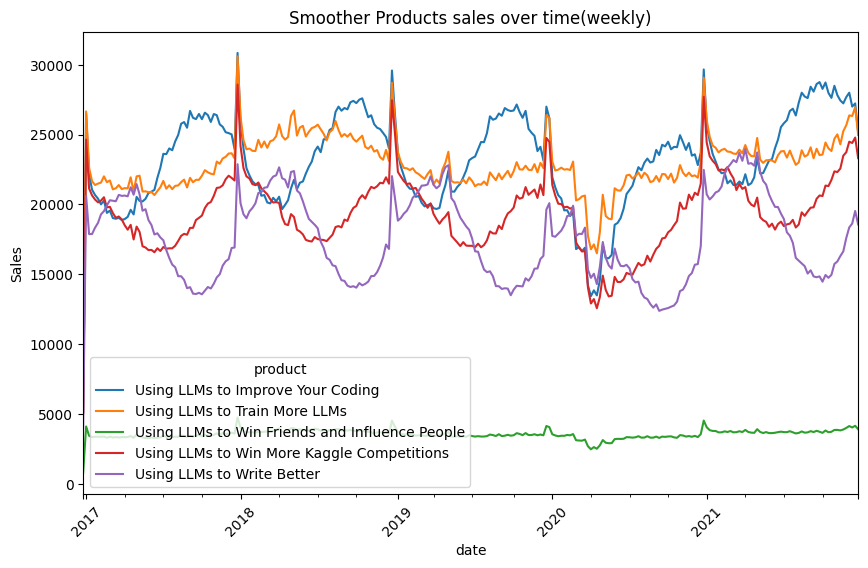

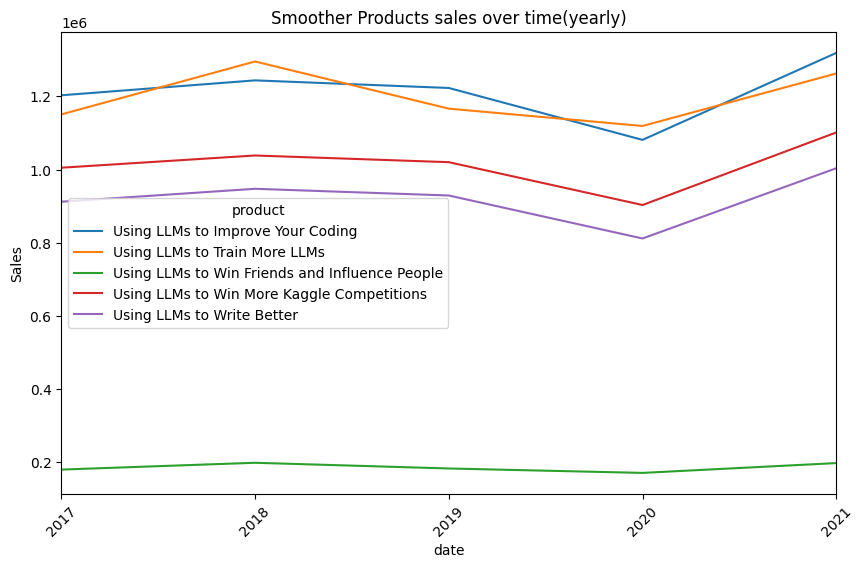

In [107]:
# Plotting pattern for product column
plot_pattern(train,'product','Products','date','Sales')

**From the above plots:**
- We see that there is a jump in the sales at the start of year for every product as before
- We can see that the same dump is also present on April 2020
- We can see that the sales of every product has great yearly seasonality except for 'Using LLMs to win friends and influence people' and 'Using LLMs to train more LLMs'

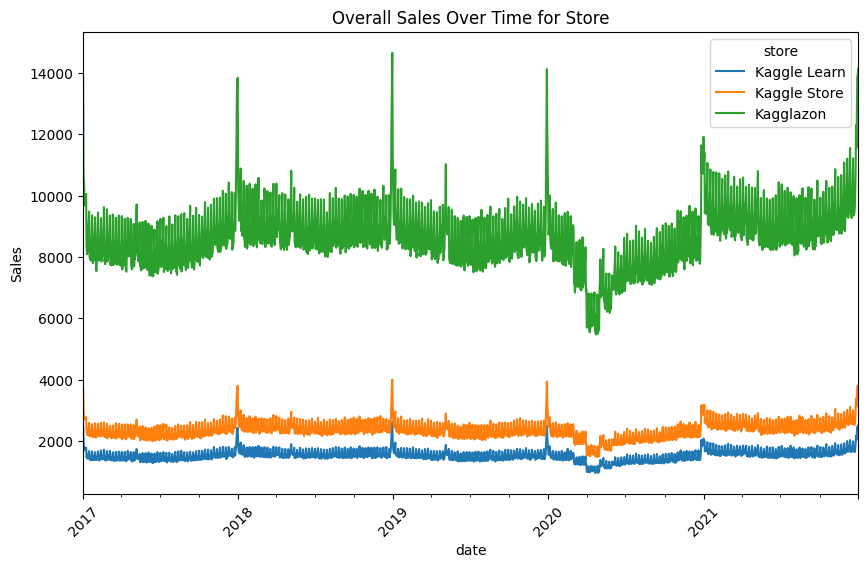

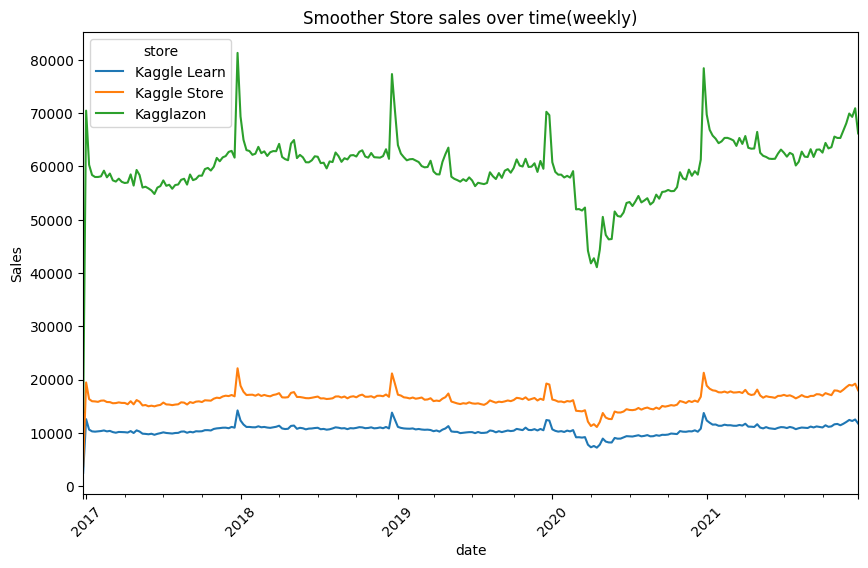

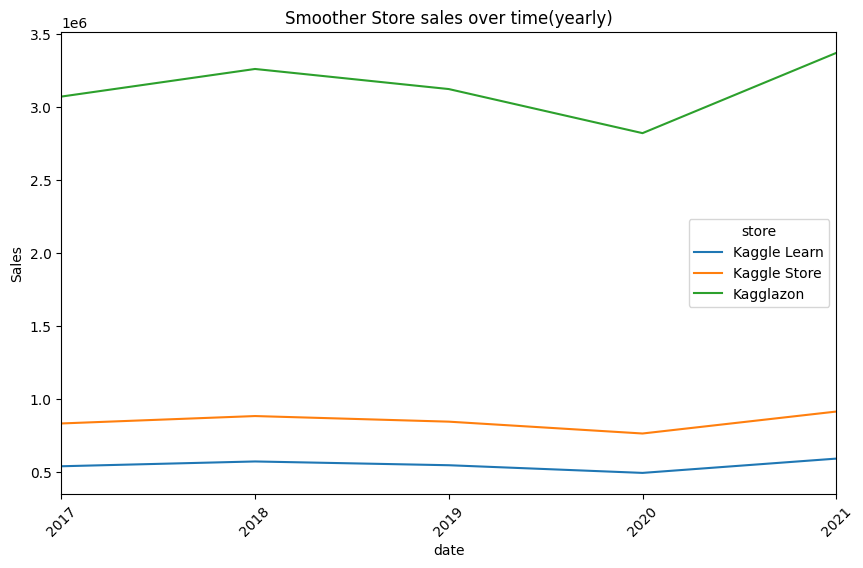

In [108]:
# Plotting pattern for store column
plot_pattern(train,'store','Store','date','Sales')

**From the above plots:**
- We can see the same jump at the start of the year
- We can see tha same dump on April 2020
- These is no prominant yearly seasonality

# Seasonality

Now we will Try to observe the seasonlaity in the data.

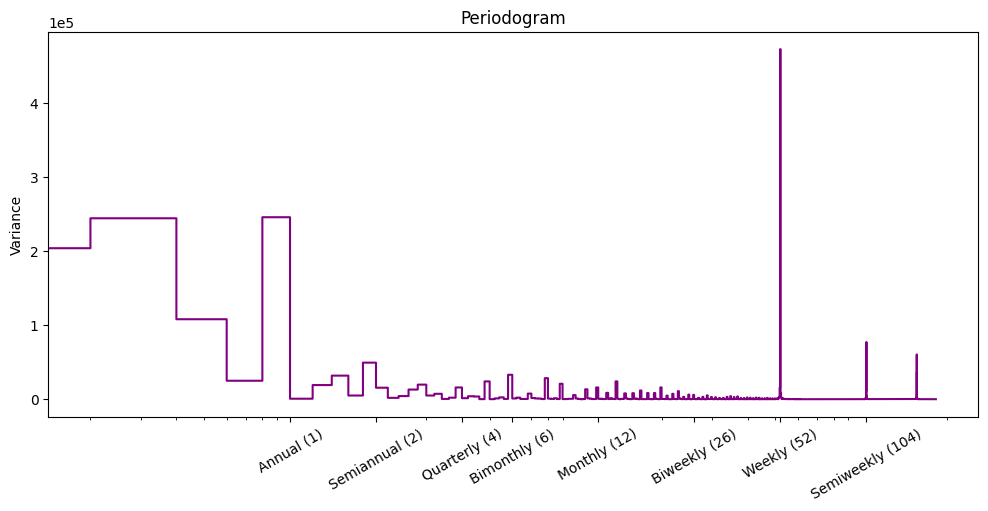

In [41]:
def plot_periodogram(ts, detrend='linear', ax=None):

    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    frequencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )

    if ax is None:
        _, ax = plt.subplots(figsize=(12, 5))

    ax.step(frequencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")

    return ax

# Astore_sales_suming your sales data is in a DataFrame named 'sales_data' with a datetime index
# Adjust this according to your actual data structure
sales_data = pd.DataFrame({'sales': np.random.rand(365)}, index=pd.date_range('2022-01-01', '2022-12-31', freq='D'))

# Use the custom plot_periodogram function
plot_periodogram(trend.num_sold)
plt.show()

We can see from the periodogram that we have annual(yearly), weekly and semiweekly seasonality. We will analyze it further

Now we will have to make seasonal column like dayofweek, dayofmonth and dayofyear

In [137]:
train['weekday'] = train.index.dayofweek
train['monthday'] = train.index.day
train['yearday'] = train.index.dayofyear

Now we will create a function that plots the weekly, monthly and yearly seasonality for every category sales over the time

In [151]:
def plot_seasonality(df, cat_col):
    fig, ax = plt.subplots(figsize=(11,5))
    weekly_seasonality = df.groupby([cat_col, 'weekday']).sum()['num_sold']
    weekly_seasonality.unstack(cat_col).plot(ax=ax)

    fig, ax = plt.subplots(figsize=(10,6))
    monthly_seasonlaity = df.groupby([cat_col, 'monthday']).sum()['num_sold']
    monthly_seasonlaity.unstack(cat_col).plot(ax=ax)

    fig, ax = plt.subplots(figsize=(10,6))
    yearly_seasonlaity = df.groupby([cat_col, 'yearday']).sum()['num_sold']
    yearly_seasonlaity.unstack(cat_col).plot(ax=ax)

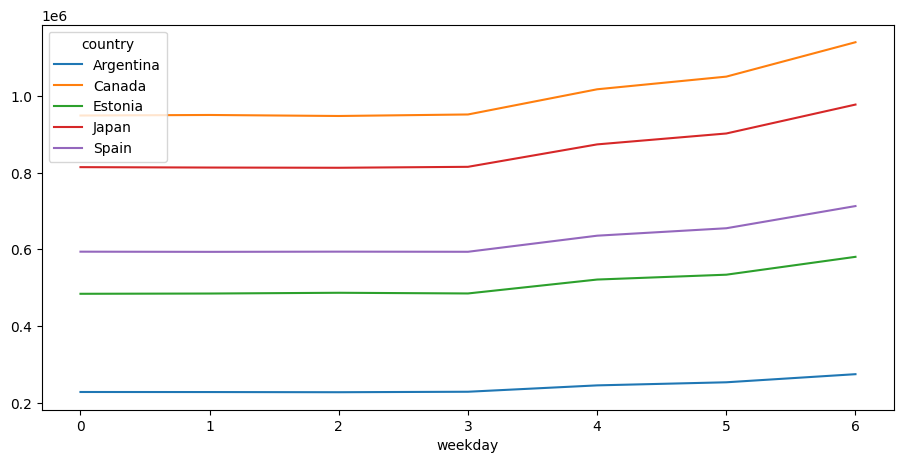

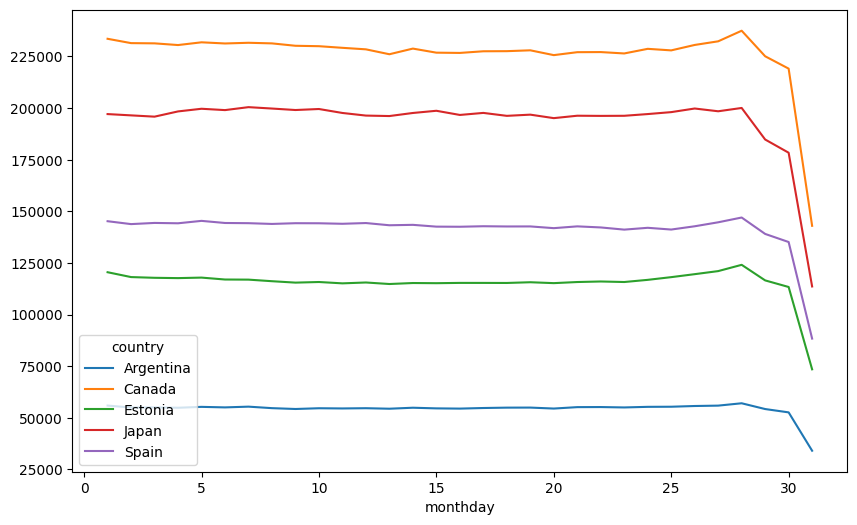

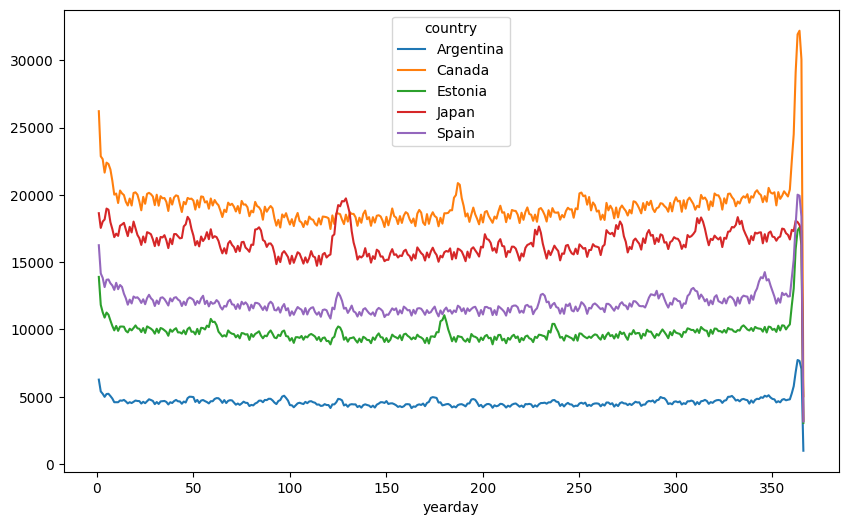

In [152]:
plot_seasonality(train, 'country')

**From the above plots:**
- We have an increase of sales at the end of the week, mainly due to weekends
- Our sales drop at the end of the month
- As observed earlier we have a jump at the start and end of the year

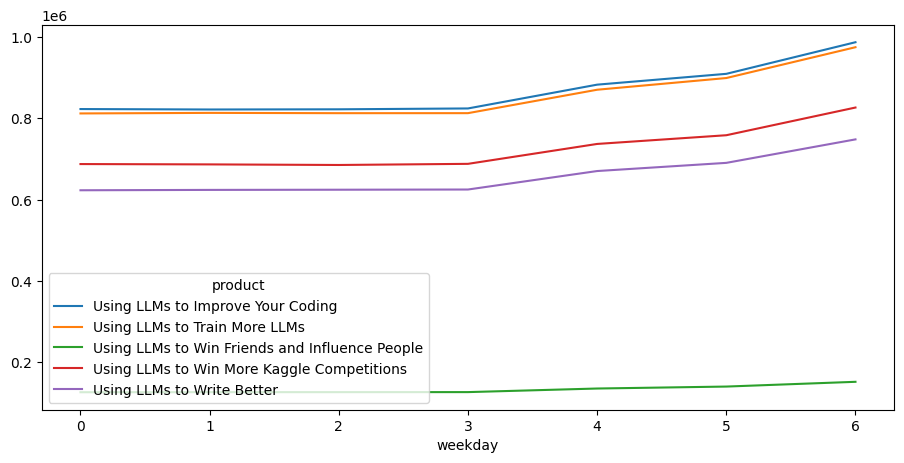

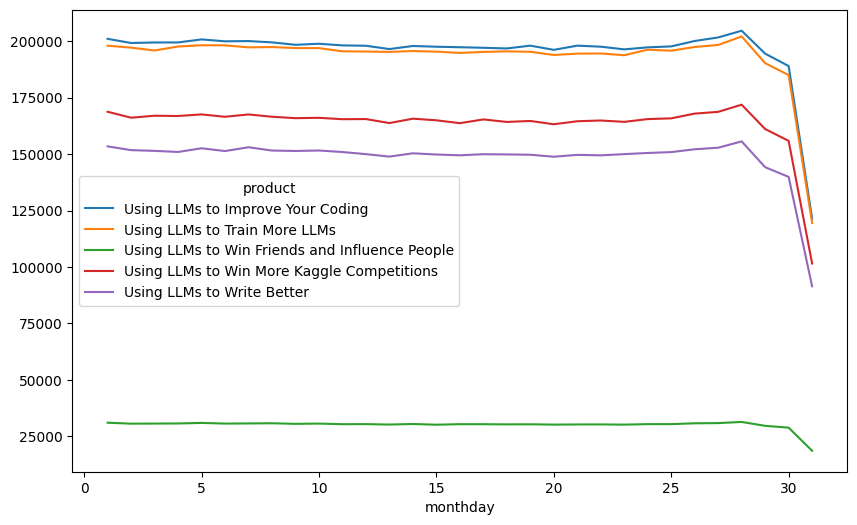

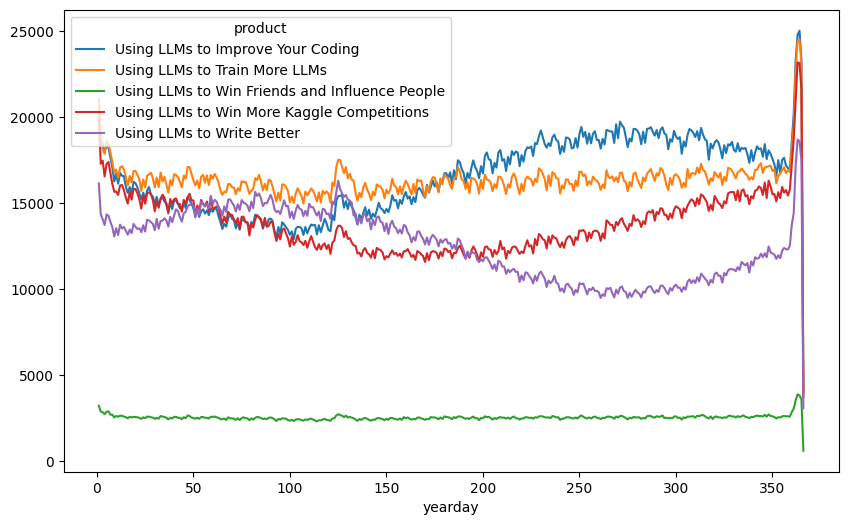

In [153]:
plot_seasonality(train, 'product')

**From the above plots:**
- We have the same weekly and monthly seasonality
- There is **different yearly seasonlity for different products** but they all have an icrease at the end and start of the year
- Also there is an jump in sales in **May** of every product

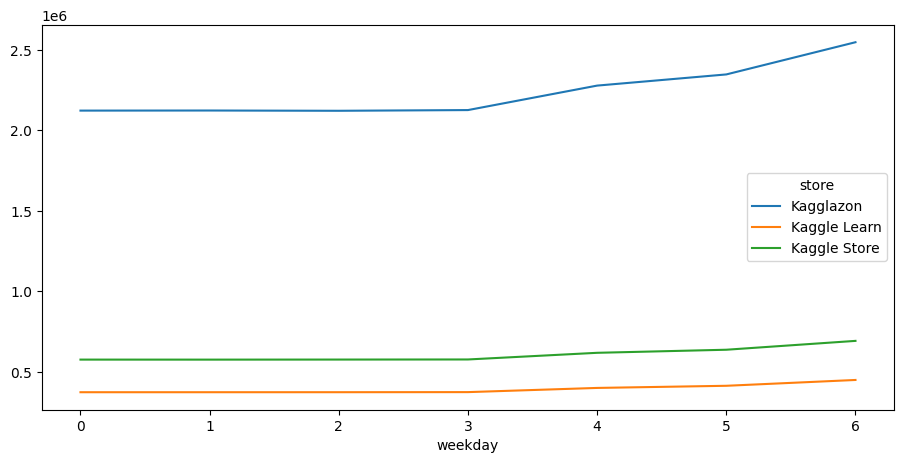

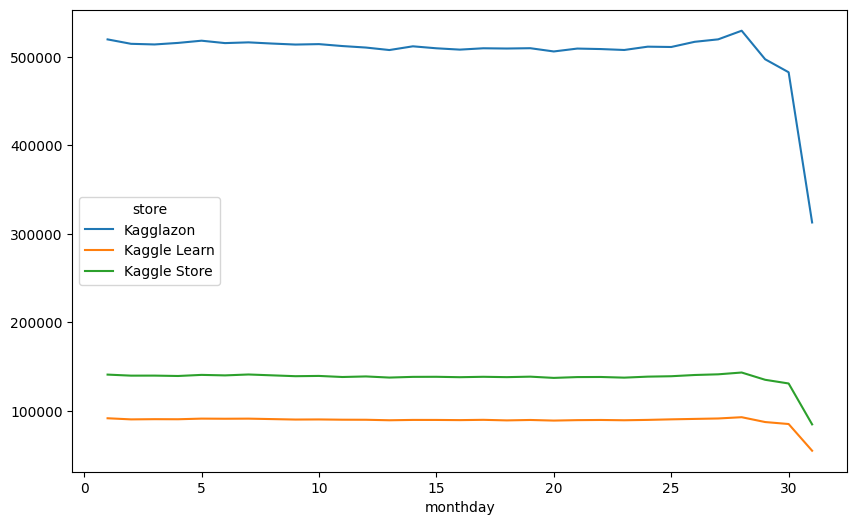

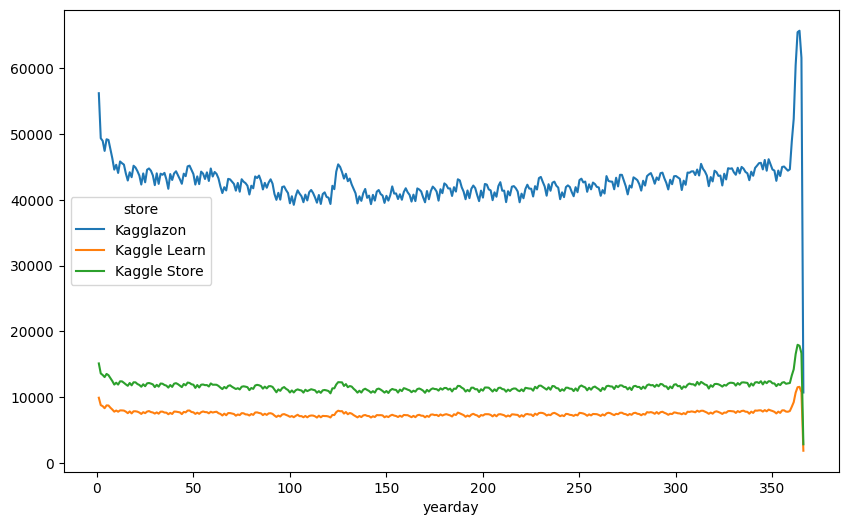

In [154]:
plot_seasonality(train, 'store')

**From the above plots:**
- We have the same **weekly and monthly seasonality**
- We don't have **yearly seasonality**. Just have the **increase in sales at the sart and end of the year** and same **jump across May**